# Train RNN with data extracted from HDFS system traces
(Example from: Property Checking with Interpretable Error Characterization)

In [13]:
from pythautomata.model_comparators.wfa_partition_comparison_strategy import WFAPartitionComparator
from pythautomata.utilities.probability_partitioner import TopKProbabilityPartitioner
from pythautomata.model_exporters.partition_mapper import TopKPartitionMapper
from pythautomata.model_exporters.wfa_image_exporter_with_partition_mapper import WFAImageExporterWithPartitionMapper
from pythautomata.base_types.symbol import SymbolStr

from pymodelextractor.learners.observation_tree_learners.bounded_pdfa_quantization_n_ary_tree_learner import BoundedPDFAQuantizationNAryTreeLearner
from pymodelextractor.teachers.pac_batch_probabilistic_teacher import PACBatchProbabilisticTeacher

from utilities.neural_networks.model_definitions import Models 
from data.data_loaders.deeplog_data_loader import DeepLogDataLoader
from utilities.neural_networks.neural_nets_train_auxiliar import load_data_and_train_last_token_language_model_network
from  tensorflow.keras.optimizers import Adam
from IPython.display import Image

### Get DataLoader 

In [14]:
dataloader = DeepLogDataLoader("./data/deep_log/hdfs_train")
alphabet = dataloader.alphabet

### Select network architecture from predefined ones 

In [15]:
has_embedding = False
input_vocab_size = len(alphabet) + 1  #to consider padding symbol
output_vocab_size = len(alphabet) + 1 #to consider terminal symbol
keras_network_architecture = Models.last_token_lstm_model(input_vocab_size, output_vocab_size, has_embedding)

### Define data generation and training parametters

In [16]:
max_sequence_length_for_training = 20
generated_training_data_size = 10000
window_size = 40
output_path="neural_networks/trained_models/hdfs_last_token_language_model/"
padding_symbol= SymbolStr('x')
terminal_symbol= SymbolStr('$')
training_params = {'patience':10, 'epochs':50, 'batch_size':100, 'learning_rate':0.01, 'criterion':Adam, 'loss':'categorical_crossentropy'}
seed = 28

In [18]:
from utilities.neural_networks.rnn_language_models.last_token_language_model import LastTokenLanguageModel
model = LastTokenLanguageModel("trained_models/hdfs_last_token_language_model/")

The model has been successfully loaded


### Generate data and Train
(These abstractions are made for the sake of simplicity, any model and architecture is valid, as long as it implements the ProbabilisticModel interface)

In [6]:
#model, eval = load_data_and_train_last_token_language_model_network(dataloader, output_path, window_size, padding_symbol, terminal_symbol, keras_network_architecture, training_params, seed, not has_embedding)

### Define Probability Partitioner

In [7]:
partitioner = TopKProbabilityPartitioner(6)

### Define a Learner, a Comparator, and a Teacher

In [9]:
comparator = WFAPartitionComparator(partitioner)

learner = BoundedPDFAQuantizationNAryTreeLearner(partitioner, max_states = 20, max_query_length = 100, max_seconds_run=20, generate_partial_hipothesis = True)

teacher  = PACBatchProbabilisticTeacher(model, epsilon = 0.05, delta = 0.05, max_seq_length = 20, comparator = comparator)

### Run extraction

In [10]:
extracted_model = learner.learn(teacher, verbose = True).model

Time Bound Reached


In [11]:
path = 'learning_outputs/'
mapped_name = extracted_model.name+"_partitioned_top_6"
WFAImageExporterWithPartitionMapper(TopKProbabilityPartitioner(
            6), TopKPartitionMapper()).export(extracted_model, path, mapped_name)


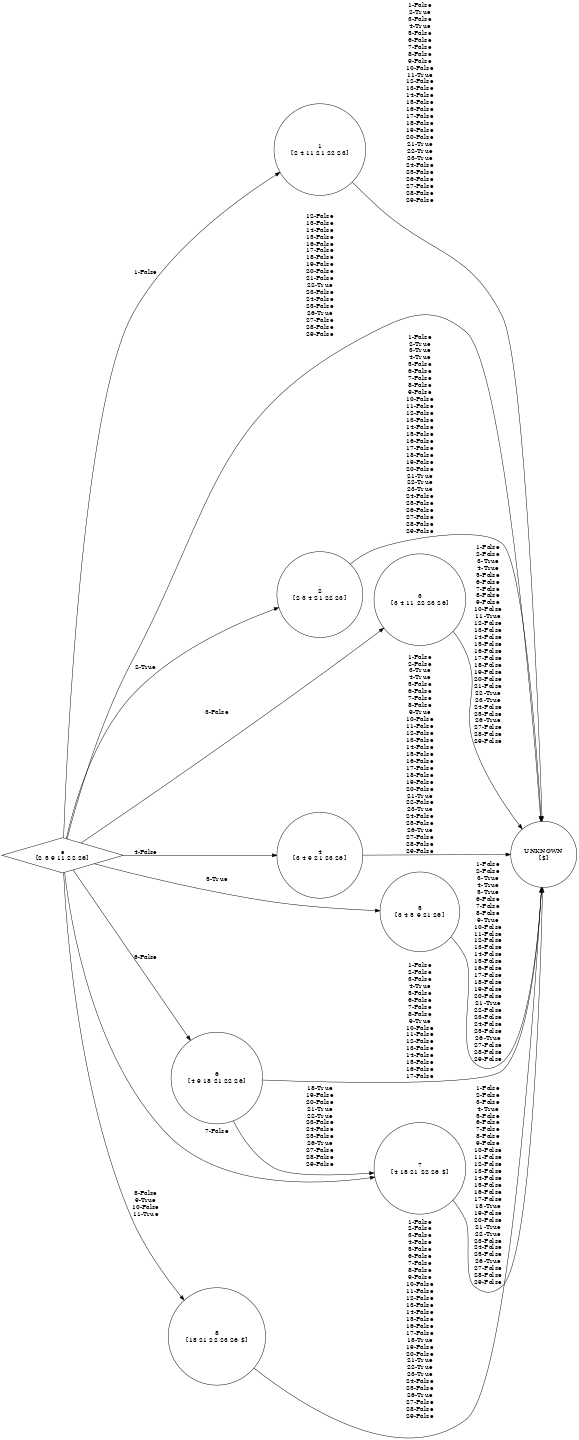

In [12]:
Image(path+mapped_name+'.png')

In [ ]:
extracted_model.export(path)
Image(path+extracted_model.name+'.png')

In [ ]:
for state in extracted_model.weighted_states:
    print(state.transitions_set)